In [1]:
#pip install opencv-python
#!pip install pydot
#!pip install graphviz

In [2]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow Sürümü:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Sürümü: 2.10.1


In [4]:
#Files
path='data'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,fire_images
1,non_fire_images


In [5]:
data_ = tf.keras.utils.image_dataset_from_directory('data')
class_names_=data_.class_names
for class_name in class_names_:
    class_path = os.path.join('data', class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} files")
    

Found 23701 files belonging to 2 classes.
fire_images: 12657 files
non_fire_images: 11044 files


In [6]:
train_data_dir =path
batch_size = 32
target_size = (128, 128)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 23701 files belonging to 2 classes.
Using 18961 files for training.
Found 23701 files belonging to 2 classes.
Using 4740 files for validation.


In [7]:
validation

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

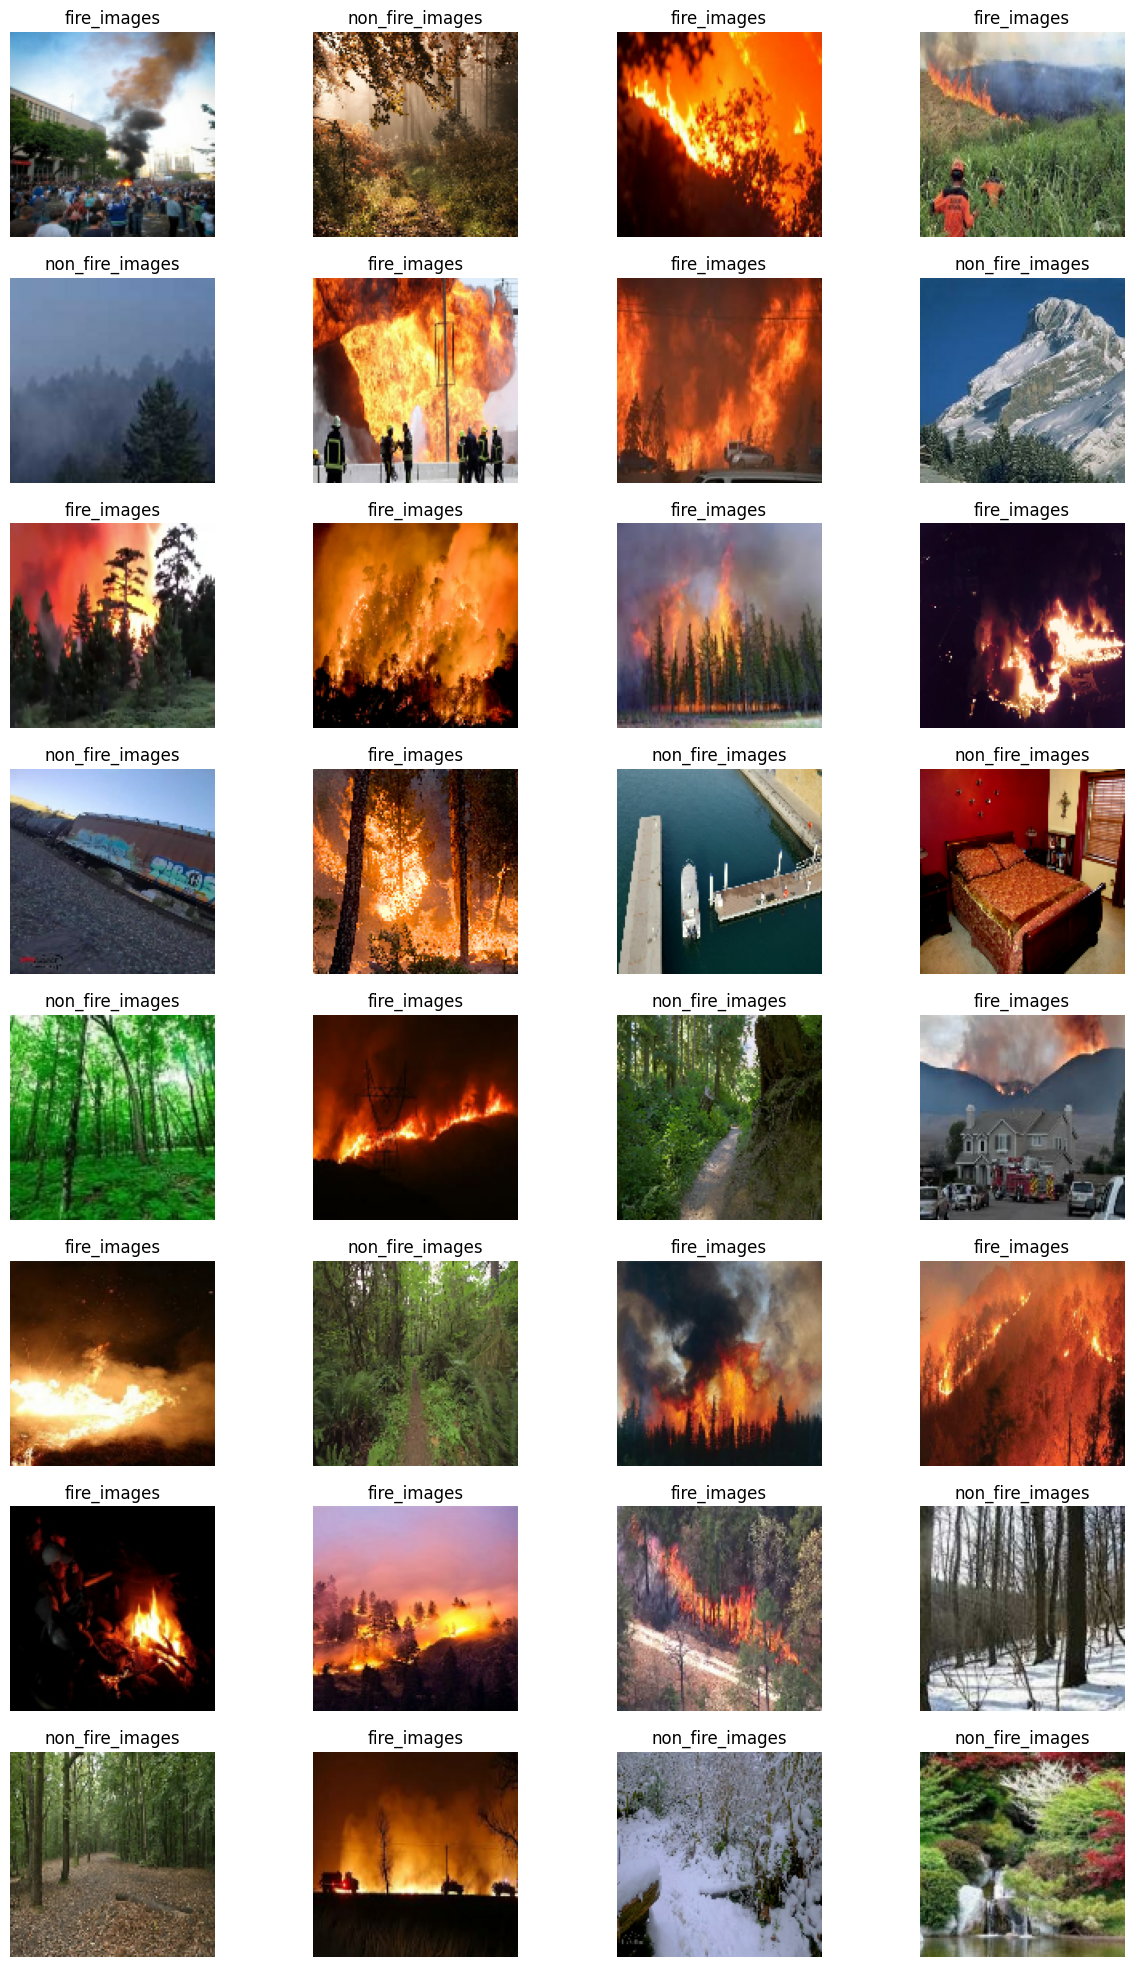

In [9]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

In [10]:
from tensorflow.keras import layers, models

In [11]:
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the base models
vgg19 = tf.keras.applications.VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
vgg19.trainable = False
vgg16 = tf.keras.applications.VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
vgg16.trainable = False
xception = tf.keras.applications.Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
xception.trainable = False
resnet = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
resnet.trainable = False
efficientnetb1 = tf.keras.applications.EfficientNetV2B0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
efficientnetb1.trainable = False
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
mobilenet.trainable = False
ConvNeXtLarge=tf.keras.applications.ConvNeXtLarge(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
ConvNeXtLarge.trainable = False

# Define input layer
input_layer = layers.Input(shape=(128, 128, 3))

# Process input through each model
vgg19_output = vgg19(input_layer, training=False)
vgg16_output = vgg16(input_layer, training=False)
xception_output = xception(input_layer, training=False)
resnet_output = resnet(input_layer, training=False)
efficientnetb1_output = efficientnetb1(input_layer, training=False)
mobilenet_output = mobilenet(input_layer, training=False)
ConvNeXtLarge_output = ConvNeXtLarge(input_layer, training=False)

# Flatten outputs
flattened_outputs = [layers.Flatten()(model_output) for model_output in [vgg19_output, vgg16_output, xception_output, resnet_output, efficientnetb1_output, mobilenet_output,ConvNeXtLarge_output]]

# Concatenate all flattened outputs
merged_output = layers.concatenate(flattened_outputs)

# Dense layer before the autoencoder
pre_autoencoder = layers.Dense(512, activation='relu')(merged_output)
pre_autoencoder = layers.Dense(256, activation='relu')(pre_autoencoder)
pre_autoencoder = layers.BatchNormalization()(pre_autoencoder)
#pre_autoencoder = layers.Dropout(0.1)(pre_autoencoder)

# Encoder
encoded = layers.Dense(128, activation='relu')(pre_autoencoder)

# Decoder
decoded = layers.Dense(sum([output.shape[1] for output in flattened_outputs]), activation='sigmoid')(encoded)

# Additional output layer for original task (e.g., classification)
output_layer = layers.Dense(1, activation='sigmoid')(encoded)

# Define the complete model with named outputs
complete_model = Model(inputs=input_layer, outputs=[decoded, output_layer], name='complete_model')

# Assign names to the outputs
decoded_output_name = 'decoded_output'
classification_output_name = 'classification_output'
complete_model.output_names = [decoded_output_name, classification_output_name]

# Compile the model with appropriate loss functions and metrics
losses = {
    decoded_output_name: 'mean_squared_error',
    classification_output_name: 'binary_crossentropy'
}
metrics = {
    classification_output_name: ['accuracy']
}
complete_model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses, metrics=metrics)

# Callbacks
#checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True,monitor='val_classification_output_accuracy')

# Train the model
history = complete_model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[
        #checkpoint_cb,
        early_stopping_cb
    ]
)

# Display the model summary
complete_model.summary()

Epoch 1/20
593/593 [==============================] - 395s 588ms/step - loss: 0.0906 - decoded_output_loss: 0.0294 - classification_output_loss: 0.0612 - classification_output_accuracy: 0.9802 - val_loss: 0.0479 - val_decoded_output_loss: 0.0055 - val_classification_output_loss: 0.0425 - val_classification_output_accuracy: 0.9941
Epoch 2/20
593/593 [==============================] - 314s 528ms/step - loss: 0.0232 - decoded_output_loss: 0.0045 - classification_output_loss: 0.0187 - classification_output_accuracy: 0.9945 - val_loss: 0.0965 - val_decoded_output_loss: 0.0021 - val_classification_output_loss: 0.0944 - val_classification_output_accuracy: 0.9977
Epoch 3/20
593/593 [==============================] - 309s 521ms/step - loss: 0.0148 - decoded_output_loss: 0.0028 - classification_output_loss: 0.0120 - classification_output_accuracy: 0.9963 - val_loss: 0.0123 - val_decoded_output_loss: 0.0022 - val_classification_output_loss: 0.0102 - val_classification_output_accuracy: 0.9973
Epoc

In [12]:
loss, decoded_output_loss,classification_output_loss,classification_output_accuracy = complete_model.evaluate(validation)
print('Test Loss =', loss)
print('decoded_output_loss =', decoded_output_loss)
print('classification_output_loss =', classification_output_loss)
print('classification_output_accuracy =', classification_output_accuracy)

149/149 [==============================] - 62s 414ms/step - loss: 0.0037 - decoded_output_loss: 8.8637e-04 - classification_output_loss: 0.0028 - classification_output_accuracy: 0.9989
Test Loss = 0.0036642218474298716
decoded_output_loss = 0.0008863667608238757
classification_output_loss = 0.0027778546791523695
classification_output_accuracy = 0.9989451766014099


In [13]:
hist_=pd.DataFrame(history.history)
hist_

,loss,decoded_output_loss,classification_output_loss,classification_output_accuracy,val_loss,val_decoded_output_loss,val_classification_output_loss,val_classification_output_accuracy
0,0.090599,0.029401,0.061198,0.980223,0.047949,0.005470,0.042478,0.994093
1,0.023192,0.004517,0.018675,0.994462,0.096505,0.002091,0.094413,0.997679
2,0.014846,0.002841,0.012005,0.996255,0.012348,0.002190,0.010158,0.997257
3,0.016126,0.003185,0.012942,0.995939,0.009486,0.001956,0.007530,0.997679
4,0.014187,0.002679,0.011508,0.996625,0.007763,0.001324,0.006438,0.998101
5,0.006882,0.001476,0.005405,0.998207,0.003664,0.000886,0.002778,0.998945
6,0.007451,0.001449,0.006002,0.998207,0.012163,0.001145,0.011018,0.998312
7,0.007686,0.001552,0.006134,0.997838,0.008351,0.000866,0.007486,0.998523
8,0.004763,0.000963,0.003800,0.998945,0.005589,0.001111,0.004477,0.998523


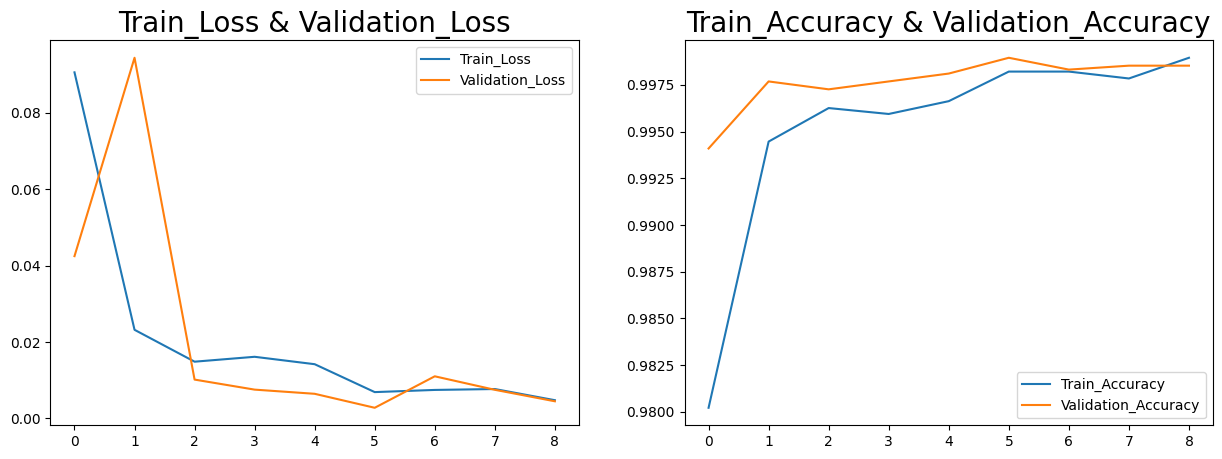

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_classification_output_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['classification_output_accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_classification_output_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [15]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=complete_model.predict(np.array(X_val))
y_pred=np.where(predictions[1]>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

149/149 [==============================] - 69s 404ms/step


,Actual,Prediction
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
4735,1,1
4736,1,1
4737,0,0
4738,1,1


In [16]:
"""plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")"""

'plt.figure(figsize=(25,25))\nfor i in range(32):\n    ax = plt.subplot(8, 4, i + 1)\n    plt.imshow(X_val[i].astype("uint8"))\n    plt.title(f\'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}\')\n    plt.axis("off")'

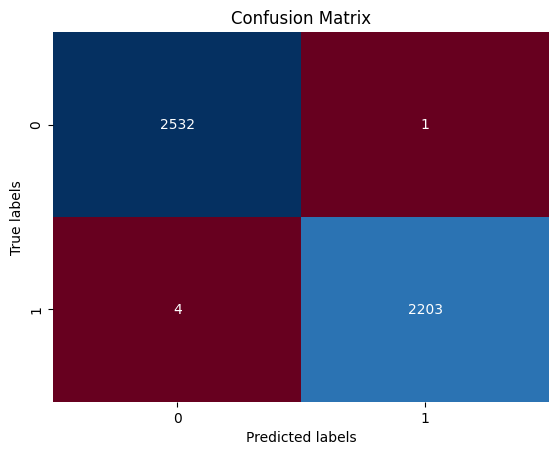

array([[2532,    1],
       [   4, 2203]], dtype=int64)

In [17]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [18]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      1.00      1.00      2533
           1       1.00      1.00      1.00      2207

    accuracy                           1.00      4740
   macro avg       1.00      1.00      1.00      4740
weighted avg       1.00      1.00      1.00      4740



# Machine Learning

In [19]:
# We are using our hybrid model as base model for machine learning models

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

feature_extractor = Model(inputs=complete_model.input, outputs=complete_model.get_layer('dense_2').output)

features = feature_extractor.predict(images)

def extract_features(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images) 
        features = features.reshape(features.shape[0], -1) 
        all_features.append(features)
        all_labels.append(labels.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = extract_features(train)
val_features, val_labels = extract_features(validation)

1/1 [==============================] - 0s 123ms/step


In [21]:
train_features.shape

(18961, 128)

In [22]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import time
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,f1_score, precision_score, recall_score, roc_auc_score, mean_absolute_error)
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
classification_models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    ExtraTreeClassifier(random_state=42),
    XGBClassifier(random_state=42),
    XGBRFClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    SGDClassifier(random_state=42),
    SVC(random_state=42)
]

def evaluate_classification_models(x_train, x_test, y_train, y_test, models):
    
    model_results = []
    trained_models = {}
    for model in models:
        model.fit(x_train, y_train)
        trained_models[model.__class__.__name__] = model  # Save trained model with name
        start_time = time.time()  # Record start time
        prediction = model.predict(x_test)
        inference_time = time.time() - start_time  # Calculate inference time

        model_results.append({
            "Model-Name": model.__class__.__name__,
            "Accuracy": accuracy_score(y_test, prediction) * 100,
            "ROC_AUC": roc_auc_score(y_test, prediction),
            "F1_Score": f1_score(y_test, prediction),
            "Precision": precision_score(y_test, prediction),
            "Recall": recall_score(y_test, prediction),
            "Inference Time (ms)": inference_time * 1000
        })

    models_df = pd.DataFrame(model_results)
    models_df = models_df.set_index('Model-Name')
    models_df = models_df.sort_values("F1_Score", ascending=False)
    return models_df, trained_models

In [23]:
print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)
print(val_labels.shape)

(18961, 128)
(18961,)
(4740, 128)
(4740,)


In [24]:
models_df, trained_models = evaluate_classification_models(train_features, val_features,train_labels, val_labels, classification_models)

In [25]:
models_df

,Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,
LogisticRegression,99.978903,0.999803,0.999773,0.999547,1.000000,0.000000
DecisionTreeClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,0.000000
XGBClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,16.414881
XGBRFClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,10.111094
AdaBoostClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,50.579786
RandomForestClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,20.231962
ExtraTreesClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,20.918846
GradientBoostingClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,6.618977
BaggingClassifier,99.978903,0.999803,0.999773,0.999547,1.000000,16.178608


In [26]:
trained_models

{'LogisticRegression': LogisticRegression(random_state=42),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
 'ExtraTreeClassifier': ExtraTreeClassifier(random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 'XGBRFClassifier': XGBRF

#We are using VGG19 as base model for machine learning models

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Önceden eğitilmiş VGG16 modelini yükle
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Ağırlıkları dondur

feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)


def extract_features(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images) 
        features = features.reshape(features.shape[0], -1) 
        all_features.append(features)
        all_labels.append(labels.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

# Eğitim ve doğrulama veri setlerinden özellikleri çıkar
train_features, train_labels = extract_features(train)
val_features, val_labels = extract_features(validation)

1/1 [==============================] - 0s 24ms/step


In [28]:
train_features.shape

(18961, 8192)

In [29]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import time
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,f1_score, precision_score, recall_score, roc_auc_score, mean_absolute_error)
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
classification_models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    ExtraTreeClassifier(random_state=42),
    XGBClassifier(random_state=42),
    XGBRFClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    SGDClassifier(random_state=42),
    SVC(random_state=42)
]

def evaluate_classification_models(x_train, x_test, y_train, y_test, models):
    
    model_results = []
    trained_models = {}
    for model in models:
        model.fit(x_train, y_train)
        trained_models[model.__class__.__name__] = model  # Save trained model with name
        start_time = time.time()  # Record start time
        prediction = model.predict(x_test)
        inference_time = time.time() - start_time  # Calculate inference time

        model_results.append({
            "Model-Name": model.__class__.__name__,
            "Accuracy": accuracy_score(y_test, prediction) * 100,
            "ROC_AUC": roc_auc_score(y_test, prediction),
            "F1_Score": f1_score(y_test, prediction),
            "Precision": precision_score(y_test, prediction),
            "Recall": recall_score(y_test, prediction),
            "Inference Time (ms)": inference_time * 1000
        })

    models_df = pd.DataFrame(model_results)
    models_df = models_df.set_index('Model-Name')
    models_df = models_df.sort_values("F1_Score", ascending=False)
    return models_df, trained_models

In [30]:
print(train_features.shape)
print(train_labels.shape)
print(val_features.shape)
print(val_labels.shape)

(18961, 8192)
(18961,)
(4740, 8192)
(4740,)


In [31]:
models_df, trained_models = evaluate_classification_models(train_features, val_features,train_labels, val_labels, classification_models)

In [32]:
models_df

,Accuracy,ROC_AUC,F1_Score,Precision,Recall,Inference Time (ms)
Model-Name,,,,,,
SGDClassifier,99.620253,0.996126,0.995918,0.996823,0.995016,6.102633e+01
ExtraTreesClassifier,99.620253,0.996097,0.995917,0.997274,0.994563,3.375657e+02
RandomForestClassifier,99.620253,0.996068,0.995915,0.997726,0.994110,3.518097e+02
LogisticRegression,99.578059,0.995615,0.995459,0.997724,0.993203,1.205513e+02
XGBClassifier,99.535865,0.995220,0.995007,0.996817,0.993203,1.197231e+02
SVC,99.409283,0.994123,0.993662,0.992763,0.994563,1.004015e+06
BaggingClassifier,99.092827,0.990637,0.990221,0.994064,0.986407,4.399498e+03
DecisionTreeClassifier,98.586498,0.985608,0.984776,0.987694,0.981876,2.836895e+01
ExtraTreeClassifier,98.016878,0.979812,0.978617,0.982640,0.974626,3.070450e+01
